# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# AWS DeepRacer Console
# stream_name = 'training-20201115184803-ehYPVaEJRxG-V3oc62Te_Q-robomaker' ## CHANGE This to your simulation application ID
fname = 'logs/local-robomaker_50.log'  # The log will be downloaded into the specified path
fname

'logs/local-robomaker_50.log'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
#from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \
    #   ActionBreakdownUtils as abu,\
    #   NewRewardUtils as nr, \ 

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500, 'display.max_columns', None)

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

AWS_track.npy
Albert.npy
AmericasGeneratedInclStart.npy
Aragon.npy
Austin.npy
Belille.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
ChampionshipCup2019_track.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
Monaco.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Singapore.npy
Spain_track.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 224 waypoints


<AxesSubplot:>

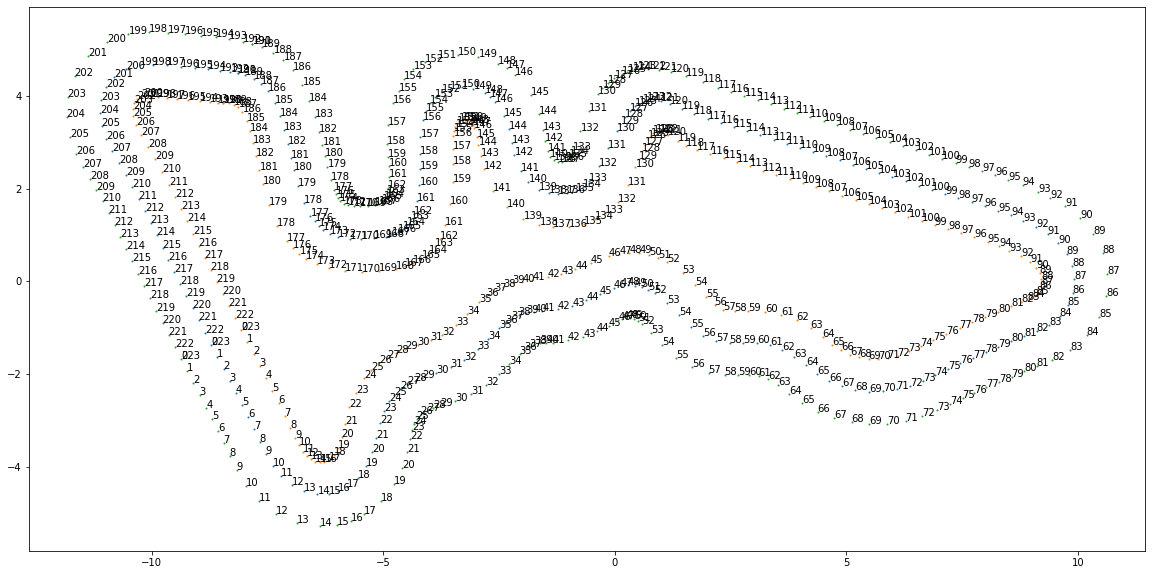

In [5]:
track: Track = tu.load_track("Austin")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# AWS DeepRacer Console
#stream_name = 'sim-test' ## CHANGE This to your simulation application ID
#fname = 'logs/%s.log' %stream_name  # The log will be downloaded into the specified path
#cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [7]:
EPISODES_PER_ITERATION = 40 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Number of episodes =  4159
Number of iterations =  104


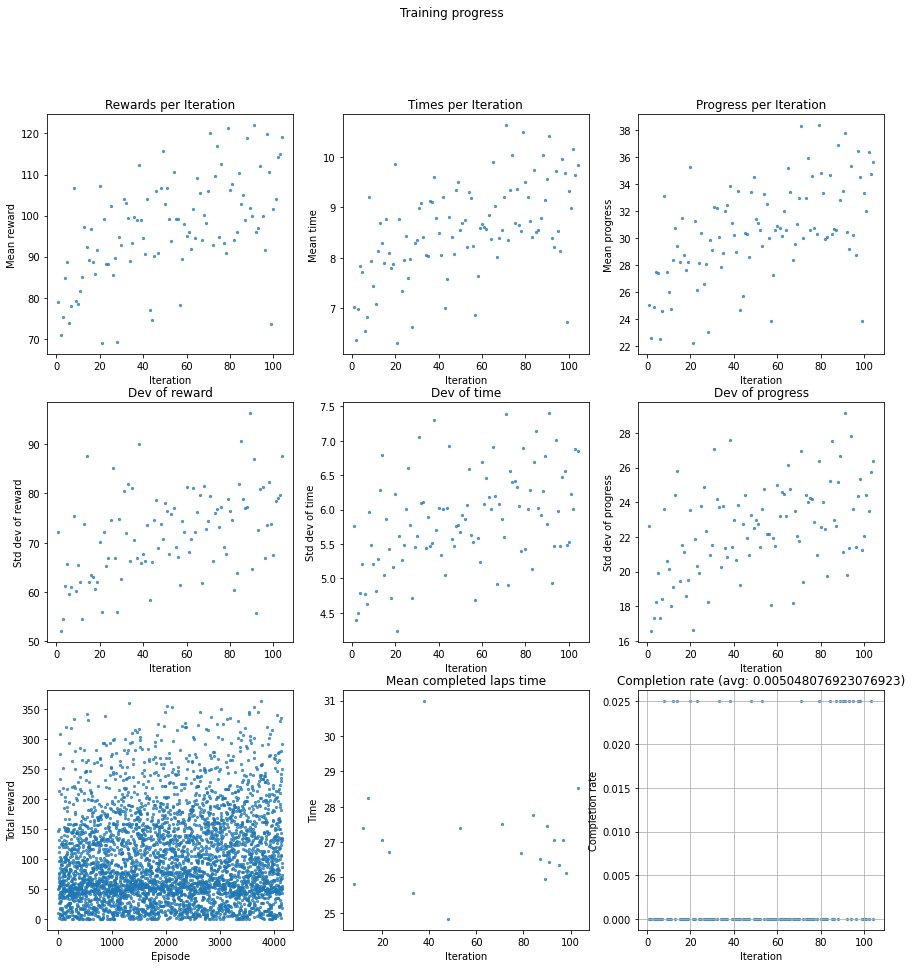

<Figure size 432x288 with 0 Axes>

In [8]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

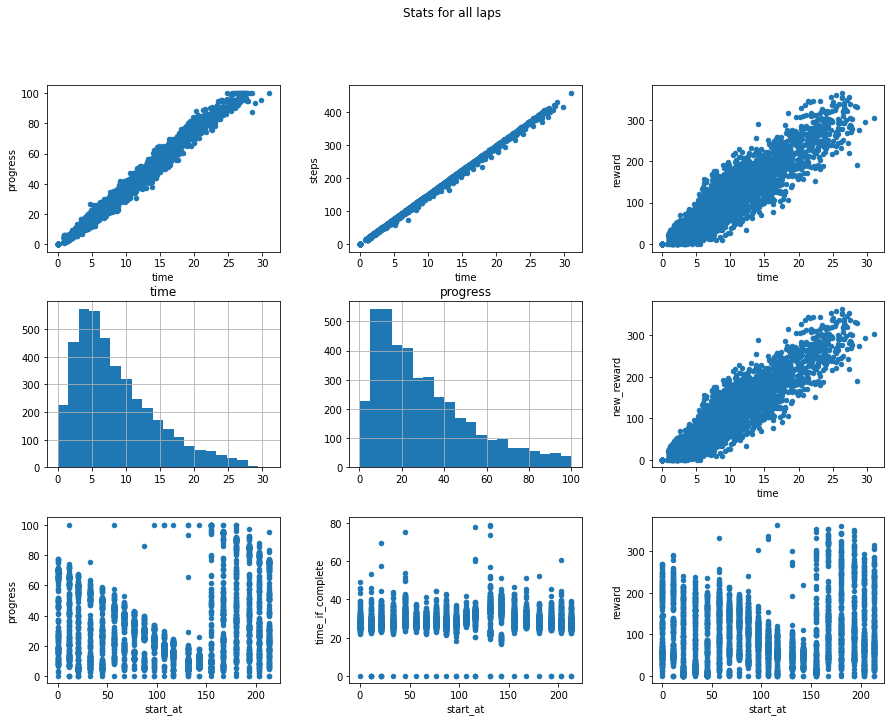

<Figure size 432x288 with 0 Axes>

In [9]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

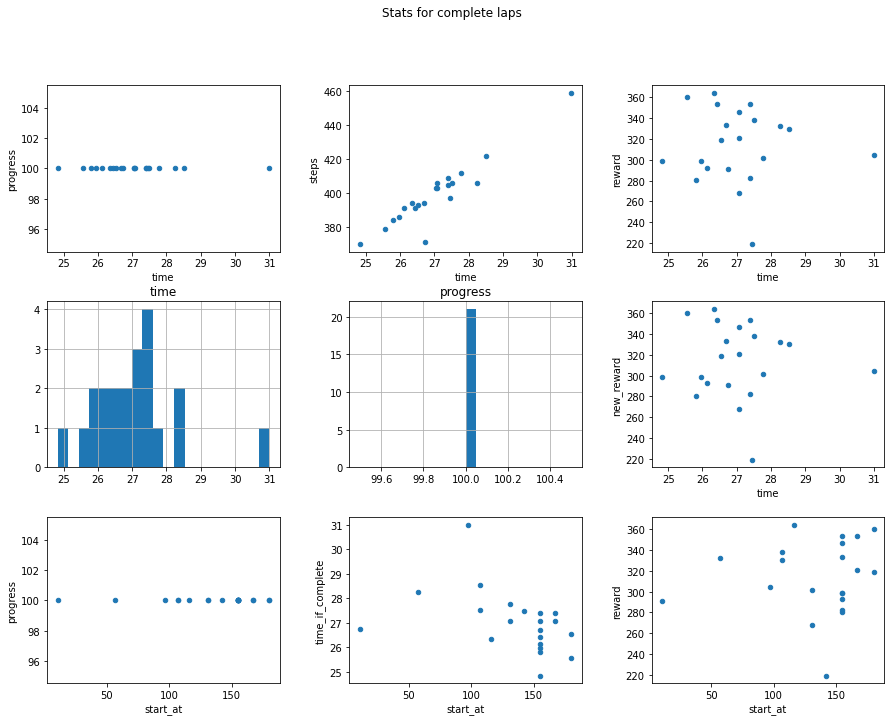

<Figure size 432x288 with 0 Axes>

In [10]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [11]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
3771         95     3771    394       116     100.0  26.339275    364.0539   
1316         33     1316    379       180     100.0  25.558649    360.1479   
3634         91     3634    391       155     100.0  26.431114    353.5038   
2115         53     2115    405       167     100.0  27.387588    353.2647   
3714         93     3714    403       155     100.0  27.051894    346.2550   
2830         71     2830    406       107     100.0  27.497851    337.8107   
3134         79     3134    394       155     100.0  26.686012    333.5083   
545          14      545    406        57     100.0  28.248425    332.0090   
4110        103     4110    422       107     100.0  28.517568    329.9153   
3875         97     3875    403       167     100.0  27.070404    320.4361   
3476         87     3476    393       180     100.0  26.527858    319.0441   
1509         38     1509    459        97     100.0  30.994698    304.2793   
3332         84     3332    412       131     100.0  27.771642    301.4126   
1914         48     1914    370       155     100.0  24.827577    299.0093   
3554         89     3554    386       155     100.0  25.954757    298.3563   
3894         98     3894    391       155     100.0  26.121048    292.4602   
881          23      881    371        11     100.0  26.732565    291.0838   
474          12      474    409       155     100.0  27.393485    282.3855   
314           8      314    384       155     100.0  25.801370    280.1736   
772          20      772    406       131     100.0  27.061935    267.8027   
3593         90     3593    397       142     100.0  27.458389    219.1045   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
3771  2.781726  364.0539         26.339275            364.0539      5th   
1316  2.769129  360.1479         25.558649            360.1479      2nd   
3634  2.680307  353.5038         26.431114            353.5038      5th   
2115  2.741975  353.2647         27.387589            353.2647      3rd   
3714  2.718362  346.2550         27.051894            346.2550      5th   
2830  2.726601  337.8107         27.497851            337.8107      4th   
3134  2.734264  333.5083         26.686012            333.5083      4th   
545   2.652709  332.0090         28.248425            332.0090      1st   
4110  2.595735  329.9153         28.517568            329.9153      5th   
3875  2.630521  320.4361         27.070404            320.4361      5th   
3476  2.680407  319.0441         26.527858            319.0441      5th   
1509  2.515033  304.2793         30.994698            304.2793      2nd   
3332  2.512621  301.4126         27.771642            301.4126      5th   
1914  2.776757  299.0093         24.827577            299.0093      3rd   
3554  2.693005  298.3563         25.954757            298.3563      5th   
3894  2.670844  292.4602         26.121048            292.4602      5th   
881   2.822642  291.0838         26.732565            291.0838      2nd   
474   2.551345  282.3855         27.393485            282.3855      1st   
314   2.728385  280.1736         25.801370            280.1736      1st   
772   2.669951  267.8027         27.061935            267.8027      1st   
3593  2.395970  219.1045         27.458389            219.1045      5th   

      complete  
3771         1  
1316         1  
3634         1  
2115         1  
3714         1  
2830         1  
3134         1  
545          1  
4110         1  
3875         1  
3476         1  
1509         1  
3332         1  
1914         1  
3554         1  
3894         1  
881          1  
474          1  
314          1  
772          1  
3593         1

In [12]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress       time  new_reward  \
314          8      314    384       155     100.0  25.801370    280.1736   
474         12      474    409       155     100.0  27.393485    282.3855   
545         14      545    406        57     100.0  28.248425    332.0090   
772         20      772    406       131     100.0  27.061935    267.8027   
881         23      881    371        11     100.0  26.732565    291.0838   

     throttle    reward  time_if_complete  reward_if_complete quintile  \
314  2.728385  280.1736         25.801370            280.1736      1st   
474  2.551345  282.3855         27.393485            282.3855      1st   
545  2.652709  332.0090         28.248425            332.0090      1st   
772  2.669951  267.8027         27.061935            267.8027      1st   
881  2.822642  291.0838         26.732565            291.0838      2nd   

     complete  
314         1  
474         1  
545         1  
772         1  
881         1

In [13]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress       time  new_reward  \
4155        104     4155    378       167   95.0848  25.785602    291.7775   
4156        104     4156     84       180   18.3953   5.687843     43.1441   
4157        104     4157    123       193   28.4184   8.353454     92.9988   
4158        104     4158    287       203   78.4427  19.695203    249.5178   
4159        104     4159    220       213   56.3197  15.055461    132.5162   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
4155  2.669048  291.7775         27.118532          306.860297      5th   
4156  2.633333   43.1441         30.920089          234.538714      5th   
4157  2.547967   92.9988         29.394525          327.248543      5th   
4158  2.966202  249.5178         25.107758          318.089255      5th   
4159  2.780000  132.5162         26.732140          235.292802      5th   

      complete  
4155         0  
4156         0  
4157         0  
4158         0  
4159         0

In [14]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==5520]

Empty DataFrame
Columns: [iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, on_track, progress, closest_waypoint, track_len, timestamp, new_reward]
Index: []

# Extract Action Space List from LOG file

In [15]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steer'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.throttle.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steer','throttle'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2))
    asl[j].rel_thr = AS.throttle[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steer.min()*dgr_norm,2)
asPlotXmax = round(df.steer.max()*dgr_norm,2)
asPlotYmin = round(df.throttle.min(),2)
asPlotYmax = round(df.throttle.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.9
1		-23.0		2.4
2		-18.9		2.6
3		-12.1		3.3
4		-8.0		2.9
5		-6.0		4.0
6		-3.4		5.0
7		-2.7		5.6
8		-0.5		4.9
9		-0.3		7.0
10		0.0		8.0
11		0.9		7.0
12		3.6		5.5
13		6.4		4.0
14		7.7		3.5
15		8.5		3.2
16		12.0		2.5
17		15.2		1.9
18		19.0		1.7
19		23.0		1.6
20		30.0		1.5


## Function definitions

In [16]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steer']*(dgr_norm), episode_data['throttle'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steer']*dgr_norm, bins=60)
    ax4.hist(episode_data['throttle'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

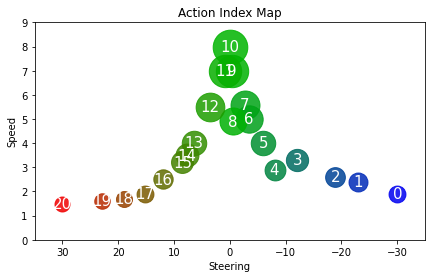

In [17]:
plot_index_map(asl)    

# Analysing data from all episodes

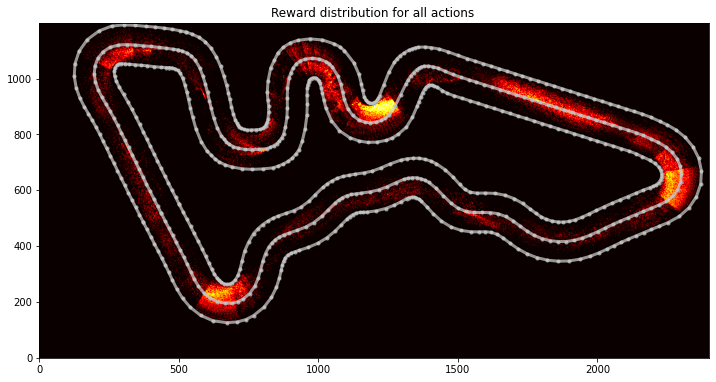

<Figure size 432x288 with 0 Axes>

In [18]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


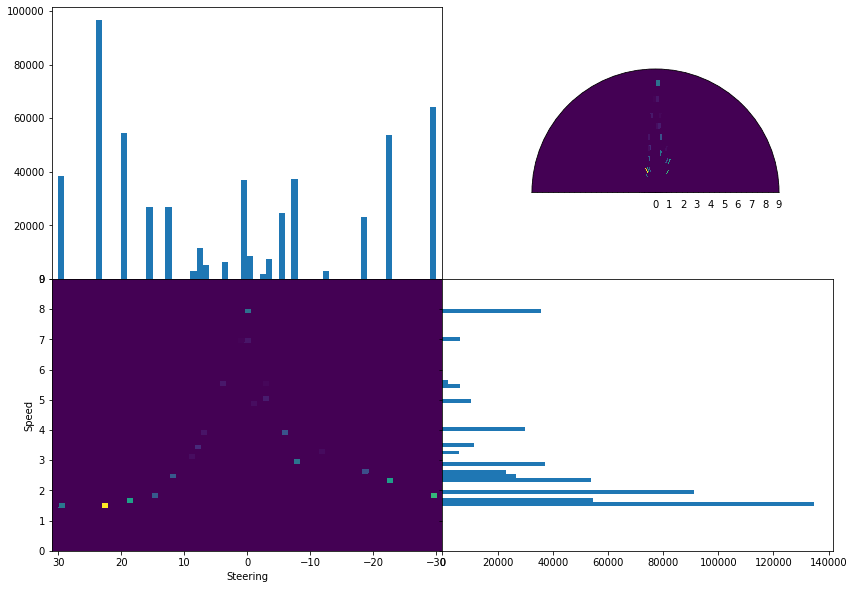

In [19]:
plot_4_hist(df)

Histogram for all episodes:


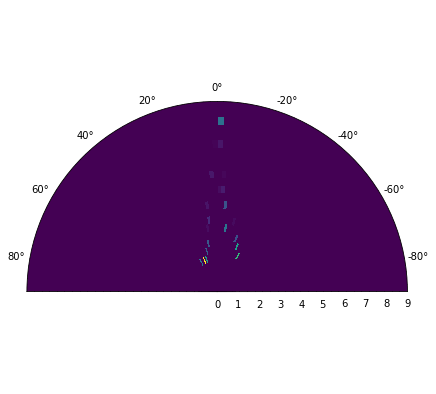

In [20]:
plot_polar_hist(df)



# Analyzing specific iteration





In [21]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()     # last iteration

In [22]:
df

iteration  episode  steps       x       y       yaw  steer  throttle  \
0               1        0      3 -8.6472 -1.5092  -62.6841   -8.0       2.9   
1               1        0      4 -8.6376 -1.5299  -62.8388    0.0       8.0   
2               1        0      5 -8.6177 -1.5744  -63.4950    0.0       8.0   
3               1        0      6 -8.5740 -1.6730  -64.5362   -3.4       5.0   
4               1        0      7 -8.5583 -1.7102  -65.0159  -23.0       2.4   
...           ...      ...    ...     ...     ...       ...    ...       ...   
529561        104     4159    216  4.8663  3.2743  108.4238   23.0       1.6   
529562        104     4159    217  4.7878  3.4134  100.9989   23.0       1.6   
529563        104     4159    218  4.7425  3.5149   95.4617   23.0       1.6   
529564        104     4159    219  4.6925  3.6525   89.6941   23.0       1.6   
529565        104     4159    220  4.6745  3.7319   85.9815   23.0       1.6   

        action  reward  done on_track  progress  closest_waypoint  track_len  \
0          4.0  0.0010     0     True    0.2744                 1      59.35   
1         10.0  2.4834     0     True    0.3128                 1      59.35   
2         10.0  2.4801     0     True    0.3947                 1      59.35   
3          6.0  0.0010     0     True    0.5762                 1      59.35   
4          1.0  0.0010     0     True    0.6440                 1      59.35   
...        ...     ...   ...      ...       ...               ...        ...   
529561    19.0  0.0010     0     True   55.7790               108      59.35   
529562    19.0  0.0010     0    False   55.9758               108      59.35   
529563    19.0  0.0010     0    False   56.1002               108      59.35   
529564    19.0  0.0010     0    False   56.2505               109      59.35   
529565    19.0  0.0010     1    False   56.3197               109      59.35   

                 timestamp  new_reward  
0       1606481241.0176442      0.0010  
1       1606481241.0853922      2.4834  
2        1606481241.152243      2.4801  
3       1606481241.2179916      0.0010  
4        1606481241.287756      0.0010  
...                    ...         ...  
529561  1606526792.9370654      0.0010  
529562   1606526793.007197      0.0010  
529563   1606526793.074926      0.0010  
529564  1606526793.1409316      0.0010  
529565  1606526793.2094812      0.0010  

[529566 rows x 17 columns]

Iteration: 104


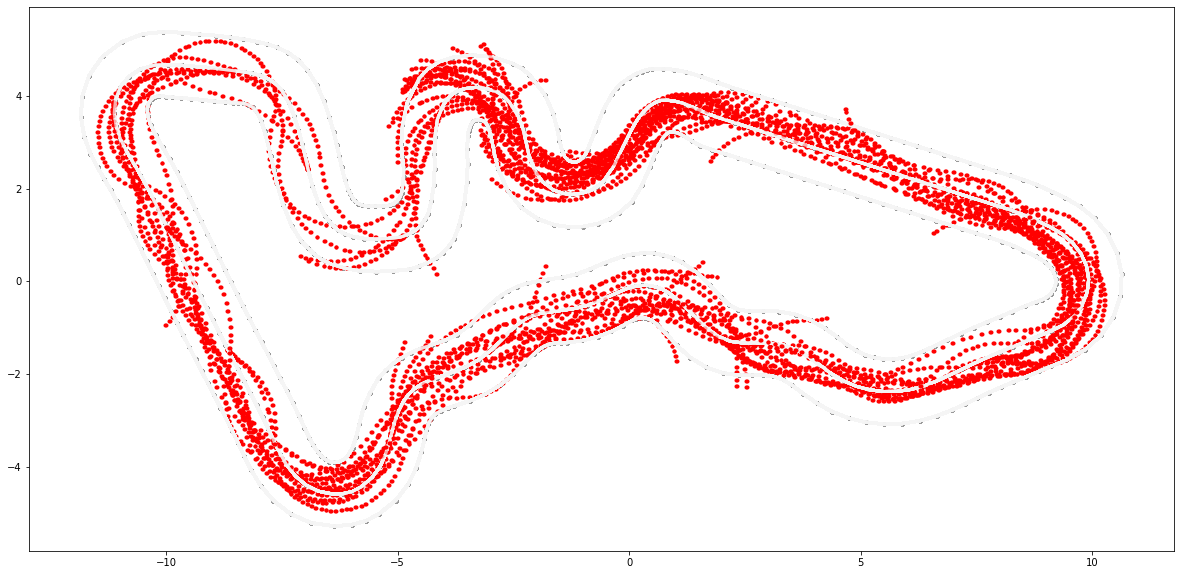

In [23]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 104


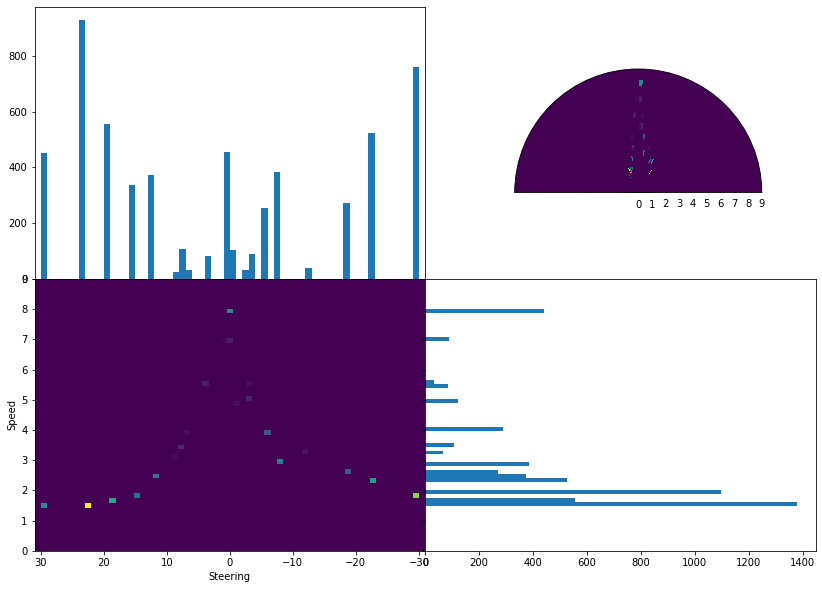

In [24]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 104


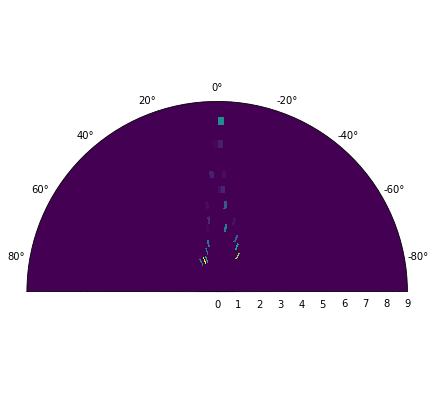

In [25]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [26]:
### choose episode id
#EPZ = 15
EPZ = df['episode'].max()
EPZ = 60
#EPZ = 442

<AxesSubplot:>

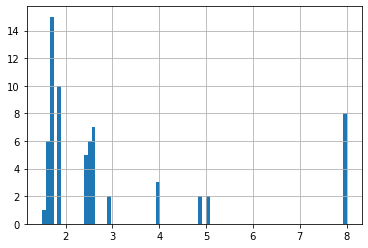

In [27]:
df[df['episode']==EPZ]['throttle'].hist(bins=80)

<AxesSubplot:>

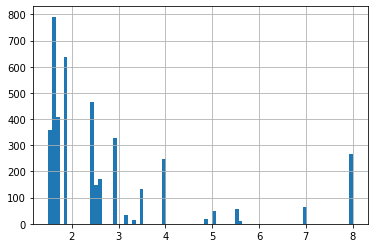

In [28]:
df[df['iteration']==1]['throttle'].hist(bins=80)

<AxesSubplot:>

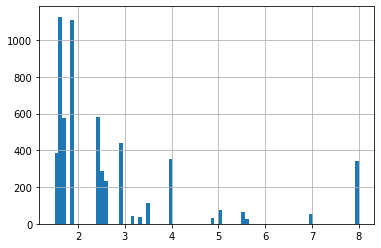

In [29]:
df[df['iteration']==65]['throttle'].hist(bins=80)

<AxesSubplot:>

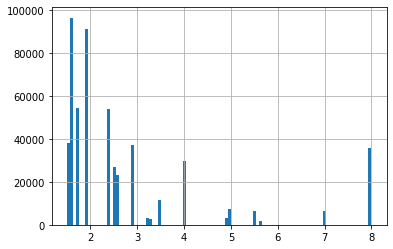

In [42]:
df['throttle'].hist(bins=100)

<AxesSubplot:>

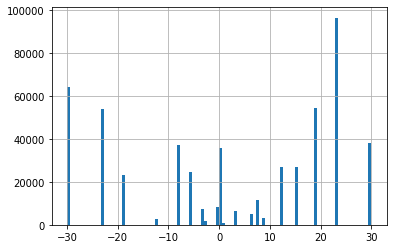

In [41]:
df['steer'].hist(bins=100)

In [32]:
df['throttle'].mean()

2.7351312206552514

In [51]:
df[df['on_track']=='False'].groupby("closest_waypoint").count()

iteration  episode  steps     x     y   yaw  steer  \
closest_waypoint                                                       
0                        94       94     94    94    94    94     94   
1                       123      123    123   123   123   123    123   
2                       108      108    108   108   108   108    108   
3                        81       81     81    81    81    81     81   
4                        88       88     88    88    88    88     88   
5                        95       95     95    95    95    95     95   
6                        90       90     90    90    90    90     90   
7                        94       94     94    94    94    94     94   
8                        73       73     73    73    73    73     73   
9                        73       73     73    73    73    73     73   
10                       62       62     62    62    62    62     62   
11                       59       59     59    59    59    59     59   
12                       58       58     58    58    58    58     58   
13                       82       82     82    82    82    82     82   
14                      112      112    112   112   112   112    112   
15                       78       78     78    78    78    78     78   
16                       66       66     66    66    66    66     66   
17                      158      158    158   158   158   158    158   
18                      213      213    213   213   213   213    213   
19                      189      189    189   189   189   189    189   
20                      114      114    114   114   114   114    114   
21                       57       57     57    57    57    57     57   
22                       40       40     40    40    40    40     40   
23                       35       35     35    35    35    35     35   
24                       46       46     46    46    46    46     46   
25                       52       52     52    52    52    52     52   
26                       83       83     83    83    83    83     83   
27                       59       59     59    59    59    59     59   
28                       58       58     58    58    58    58     58   
29                      106      106    106   106   106   106    106   
30                       96       96     96    96    96    96     96   
31                      102      102    102   102   102   102    102   
32                      114      114    114   114   114   114    114   
33                      157      157    157   157   157   157    157   
34                      255      255    255   255   255   255    255   
35                      203      203    203   203   203   203    203   
36                       93       93     93    93    93    93     93   
37                       94       94     94    94    94    94     94   
38                       70       70     70    70    70    70     70   
39                      117      117    117   117   117   117    117   
40                      257      257    257   257   257   257    257   
41                      241      241    241   241   241   241    241   
42                      196      196    196   196   196   196    196   
43                       88       88     88    88    88    88     88   
44                       99       99     99    99    99    99     99   
45                      213      213    213   213   213   213    213   
46                      176      176    176   176   176   176    176   
47                      101      101    101   101   101   101    101   
48                       92       92     92    92    92    92     92   
49                       19       19     19    19    19    19     19   
50                       87       87     87    87    87    87     87   
51                      100      100    100   100   100   100    100   
52                      240      240    240   240   240   240    240   
53                      263      263    263   263   263   

In [44]:
df.groupby("closest_waypoint").mean()

iteration      episode       steps          x         y  \
closest_waypoint                                                            
0                 53.076680  2104.868775   49.908300  -8.876801 -1.550026   
1                 52.659033  2086.339876   44.392948  -8.749531 -1.692895   
2                 52.811390  2095.091116   55.925285  -8.648265 -1.982317   
3                 53.260301  2113.403296   60.037809  -8.524181 -2.249907   
4                 53.560807  2125.734121   62.912851  -8.392874 -2.515123   
5                 53.068534  2106.009505   64.119560  -8.263541 -2.778161   
6                 53.270791  2113.944219   66.289047  -8.129347 -3.034730   
7                 53.436459  2120.709186   67.548310  -8.011666 -3.297983   
8                 52.850488  2097.349157   70.048358  -7.867737 -3.554036   
9                 53.329745  2116.692185   73.416268  -7.693804 -3.804694   
10                52.819318  2096.384470   76.606818  -7.484677 -4.038521   
11                53.068345  2102.087530   53.859472  -7.232055 -4.207082   
12                52.493519  2081.229012   68.908025  -6.964446 -4.365266   
13                52.413805  2078.476305   73.666896  -6.692969 -4.452887   
14                52.598969  2085.716382   75.801666  -6.428322 -4.466264   
15                52.404408  2078.334435   79.099725  -6.204942 -4.478510   
16                52.615335  2087.017544   81.708902  -6.004924 -4.467530   
17                52.748418  2091.814599   81.108029  -5.831595 -4.336190   
18                53.094286  2105.758776   82.928163  -5.614372 -4.182652   
19                52.829472  2094.913027   83.470186  -5.420456 -3.953925   
20                52.917005  2098.352269   84.675028  -5.256204 -3.685694   
21                52.878821  2093.992358   62.397380  -5.116372 -3.370733   
22                52.995943  2099.076403   68.423597  -5.014324 -3.099485   
23                52.894166  2095.633198   75.257802  -4.893624 -2.853409   
24                52.897213  2095.750290   77.095819  -4.821012 -2.641507   
25                52.824792  2093.144737   81.072715  -4.736598 -2.469262   
26                52.690909  2087.184615   81.872028  -4.646844 -2.308958   
27                53.640808  2125.863755   84.183833  -4.471508 -2.244140   
28                52.830608  2093.351864   85.097449  -4.321989 -2.137970   
29                52.892442  2096.182171   86.698643  -4.134729 -2.030502   
30                53.158468  2106.498790   86.006048  -3.877759 -1.902592   
31                53.337064  2113.342230   86.230736  -3.577275 -1.788254   
32                52.659108  2086.171791   87.559570  -3.250161 -1.678574   
33                52.492617  2077.299723   62.286802  -2.922641 -1.531208   
34                52.677215  2085.986479   80.061853  -2.589707 -1.380772   
35                52.797794  2091.114430   84.147978  -2.338031 -1.241597   
36                54.651226  2165.006358   81.809264  -2.205234 -1.122662   
37                54.645793  2164.986301   82.596869  -2.090576 -1.057851   
38                54.502744  2159.465423   82.040615  -1.987433 -0.971155   
39                54.576067  2161.891466   82.894249  -1.855880 -0.948440   
40                53.932622  2136.263509   87.289526  -1.695668 -0.972770   
41                54.300485  2151.120874   89.130583  -1.489462 -0.879330   
42                53.877226  2134.310724   90.909056  -1.198573 -0.795493   
43                54.060769  2141.667218   92.533278  -0.867418 -0.687459   
44                54.815335  2171.558410   92.588920  -0.538347 -0.591363   
45                53.712894  2125.659574   60.159190  -0.266865 -0.434211   
46                53.645596  2123.458031   74.993264   0.008659 -0.388597   
47                53.236098  2107.469268   78.366829   0.168918 -0.346387   
48                54.602073  2161.515026   77.801036   0.293415 -0.353912   
49                52.338534  2071.478939   79.358814   0.411627 -0.247715   
50            

In [33]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1          2.439143  2.729643
2          2.011512  2.821628
3          2.315836  2.844945
4          1.983567  2.783912
5          2.864463  2.798164
6          2.354268  2.726788
7          1.839465  2.847692
8          2.417174  2.769404
9          2.678364  2.684756
10         2.216033  2.711126
11         1.986250  2.758514
12         2.450371  2.684192
13         2.061195  2.721848
14         2.161756  2.789718
15         2.477901  2.746775
16         2.339245  2.725114
17         2.554679  2.755987
18         2.994515  2.723839
19         2.263669  2.768844
20         2.928724  2.753020
21         1.901452  2.792003
22         1.957156  2.750715
23         2.028965  2.779757
24         2.124328  2.733929
25         1.584007  2.800398
26         2.624577  2.734194
27         2.870075  2.702137
28         2.345532  2.704933
29         2.157065  2.777429
30         2.311241  2.703405
31         2.509524  2.731839
32         2.178208  2.748972
33         2.275909  2.716703
34         2.554979  2.746709
35         2.276874  2.767739
36         2.125403  2.696461
37         2.268812  2.778157
38         2.211205  2.714536
39         2.219022  2.695570
40         2.622187  2.720906
41         2.128462  2.723770
42         2.336530  2.747048
43         2.275988  2.730644
44         2.896707  2.646662
45         2.138826  2.716517
46         2.235843  2.785422
47         2.135674  2.731452
48         2.091063  2.700613
49         2.434874  2.750732
50         1.920160  2.791730
51         1.935679  2.745303
52         2.292566  2.674282
53         2.022797  2.730857
54         1.968696  2.793948
55         2.142439  2.712212
56         2.143858  2.811475
57         2.180463  2.736248
58         2.173269  2.737129
59         2.273699  2.657455
60         2.262240  2.754475
61         2.052508  2.706979
62         2.425454  2.717893
63         2.098615  2.752125
64         2.002555  2.721481
65         1.792416  2.663952
66         2.141726  2.800957
67         2.440000  2.695338
68         1.991189  2.735282
69         2.232963  2.731423
70         1.897870  2.718397
71         2.347380  2.753355
72         2.151389  2.739760
73         2.073075  2.695149
74         2.201231  2.764581
75         2.344486  2.679172
76         2.325339  2.801069
77         2.580353  2.723588
78         1.948338  2.659390
79         2.439578  2.753657
80         2.072361  2.753663
81         2.507104  2.717551
82         1.935940  2.617718
83         1.981943  2.687426
84         2.437714  2.671654
85         2.299901  2.736532
86         2.299960  2.747951
87         2.280683  2.686399
88         2.360629  2.750452
89         2.308136  2.744496
90         2.493857  2.678722
91         2.038339  2.775677
92         2.115097  2.782614
93         2.170569  2.740159
94         2.363504  2.757076
95         2.300687  2.717007
96         2.790583  2.667124
97         2.284262  2.736210
98         2.499271  2.686148
99         2.000949  2.759411
100        2.364422  2.702705
101        2.052203  2.705707
102        2.284568  2.731148
103        2.394212  2.728343
104        1.909219  2.808445

In [34]:
df[df['episode']==EPZ]

iteration  episode  steps       x       y      yaw  steer  throttle  \
6088          2       60      1 -8.6571 -1.4891 -62.5418    0.0       8.0   
6089          2       60      2 -8.6536 -1.4951 -62.4010   -8.0       2.9   
6090          2       60      3 -8.6379 -1.5204 -61.8791    0.0       8.0   
6091          2       60      4 -8.6147 -1.5524 -60.5867  -18.9       2.6   
6092          2       60      5 -8.5864 -1.5959 -59.7374  -30.0       1.9   
6093          2       60      6 -8.5570 -1.6530 -60.5715  -30.0       1.9   
6094          2       60      7 -8.5283 -1.7241 -62.8484   -6.0       4.0   
6095          2       60      8 -8.5000 -1.7982 -64.7833   -3.4       5.0   
6096          2       60      9 -8.4556 -1.9094 -66.3916  -23.0       2.4   
6097          2       60     10 -8.4198 -2.0254 -69.3227    0.0       8.0   
6098          2       60     11 -8.3837 -2.1666 -72.5930   12.0       2.5   
6099          2       60     12 -8.3501 -2.3080 -74.7069    0.0       8.0   
6100          2       60     13 -8.3136 -2.4562 -75.4929   19.0       1.7   
6101          2       60     14 -8.2776 -2.6053 -76.2691   19.0       1.7   
6102          2       60     15 -8.2253 -2.7639 -73.6794   19.0       1.7   
6103          2       60     16 -8.1863 -2.8617 -71.4960    0.0       8.0   
6104          2       60     17 -8.1282 -2.9849 -68.2301  -23.0       2.4   
6105          2       60     18 -8.0525 -3.1524 -66.5836   15.2       1.9   
6106          2       60     19 -8.0029 -3.2604 -66.0516   19.0       1.7   
6107          2       60     20 -7.9318 -3.3971 -64.1225   19.0       1.7   
6108          2       60     21 -7.8612 -3.5065 -60.8610   19.0       1.7   
6109          2       60     22 -7.7852 -3.6048 -57.0101   15.2       1.9   
6110          2       60     23 -7.6987 -3.6996 -52.7527   19.0       1.7   
6111          2       60     24 -7.6102 -3.7835 -48.6588   15.2       1.9   
6112          2       60     25 -7.5061 -3.8643 -43.6891   19.0       1.7   
6113          2       60     26 -7.3931 -3.9373 -38.5512   19.0       1.7   
6114          2       60     27 -7.3053 -3.9860 -35.0276   19.0       1.7   
6115          2       60     28 -7.1972 -4.0363 -30.7058   19.0       1.7   
6116          2       60     29 -7.0685 -4.0845 -25.8577   15.2       1.9   
6117          2       60     30 -6.9907 -4.1066 -22.7194   23.0       1.6   
6118          2       60     31 -6.8591 -4.1299 -16.7068   19.0       1.7   
6119          2       60     32 -6.7388 -4.1402 -11.5512   12.0       2.5   
6120          2       60     33 -6.6115 -4.1405  -6.3333   19.0       1.7   
6121          2       60     34 -6.4768 -4.1267  -0.3385   23.0       1.6   
6122          2       60     35 -6.3709 -4.1074   3.8998   15.2       1.9   
6123          2       60     36 -6.2651 -4.0804   8.1204   12.0       2.5   
6124          2       60     37 -6.1288 -4.0323  13.7994  -18.9       2.6   
6125          2       60     38 -6.0331 -3.9886  17.9877   12.0       2.5   
6126          2       60     39 -5.8919 -3.9145  23.2010   -0.5       4.9   
6127          2       60     40 -5.7508 -3.8245  28.8602   19.0       1.7   
6128          2       60     41 -5.6315 -3.7299  35.5216  -23.0       2.4   
6129          2       60     42 -5.5306 -3.6366  40.9086   -0.5       4.9   
6130          2       60     43 -5.3933 -3.4869  46.5352   -8.0       2.9   
6131          2       60     44 -5.2921 -3.3620  49.8204   12.0       2.5   
6132          2       60     45 -5.1965 -3.2342  51.6217   -6.0       4.0   
6133          2       60     46 -5.1151 -3.1173  53.3065  -18.9       2.6   
6134          2       60     47 -5.0028 -2.9569  54.4881  -18.9       2.6   
6135          2       60     48 -4.8825 -2.8007  53.1291  -18.9       2.6   
6136          2       60     49 -4.7647 -2.6642  50.7531  -18.9       2.6   
6137          2       60     50 -4.6413 -2.5390  47.6276  -18.9       2.6   
6138          2       60     51 -4.5846 -2.4874  45.9641   -3.4       5.0   
61

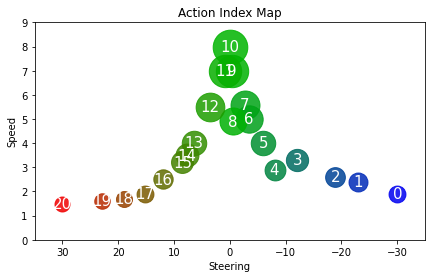

In [35]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


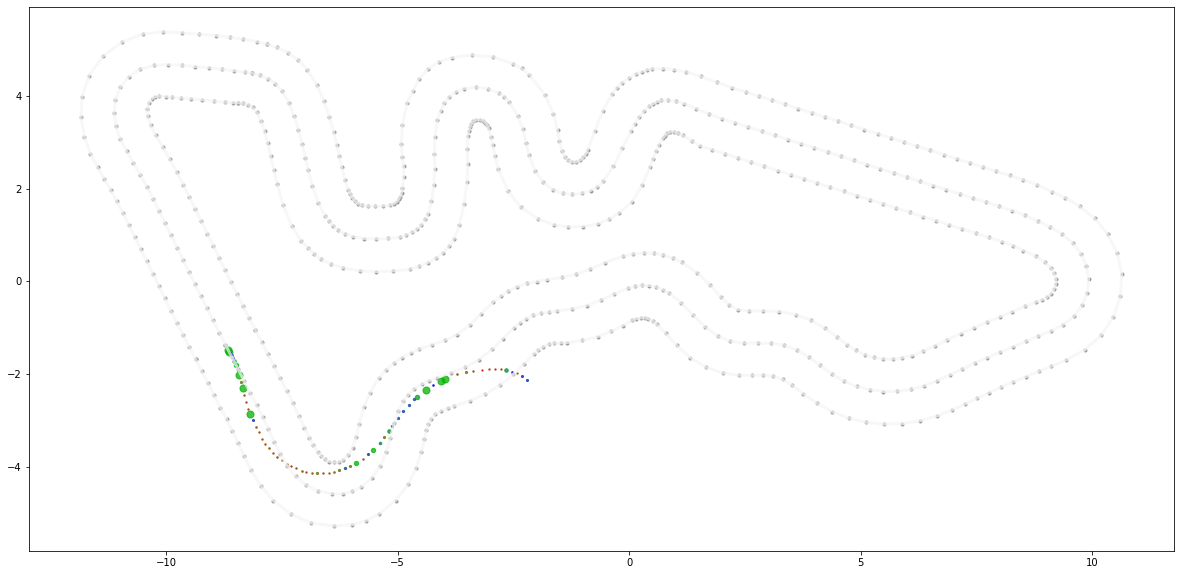

In [36]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
#EPZ = 31
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 60


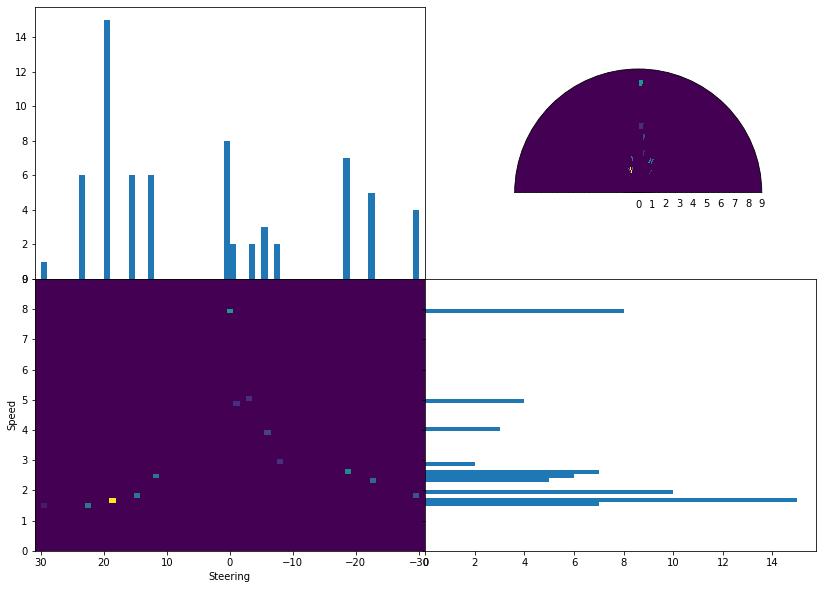

In [37]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 60


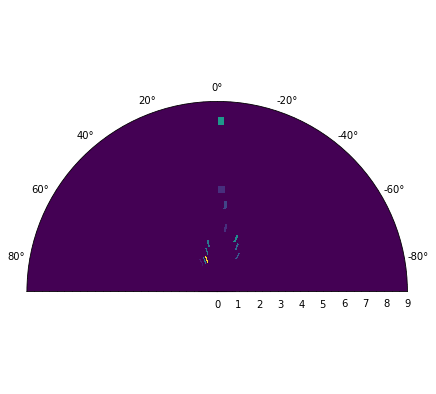

In [38]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

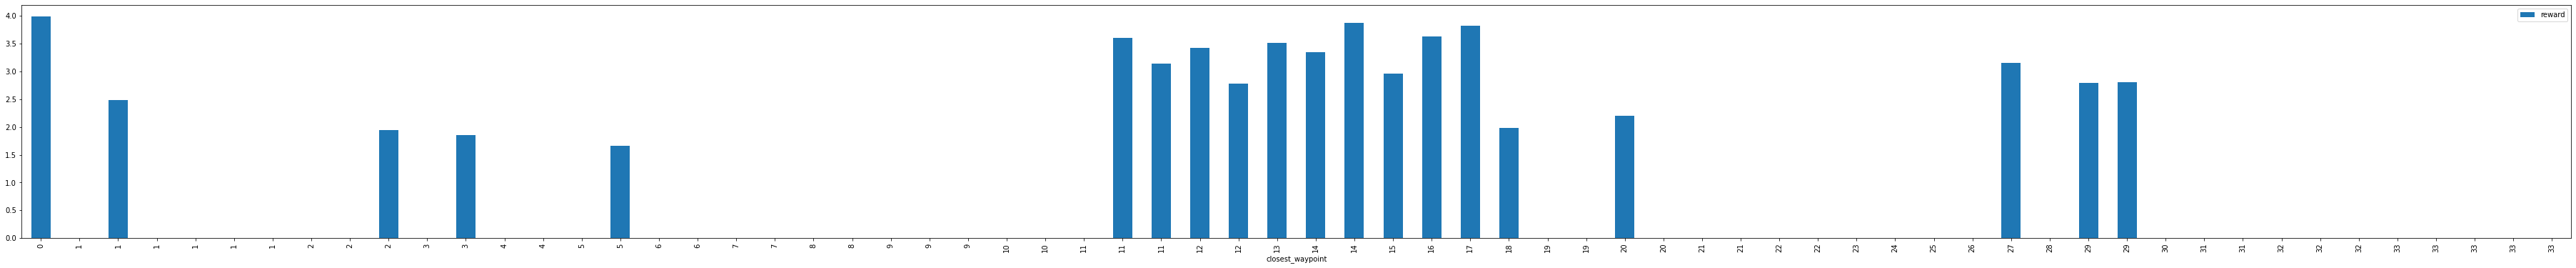

In [39]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(64, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.9


<Figure size 432x288 with 0 Axes>

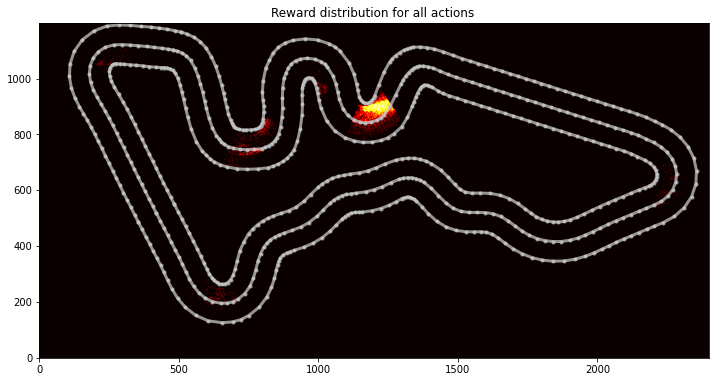

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -23.0, throttle: 2.4


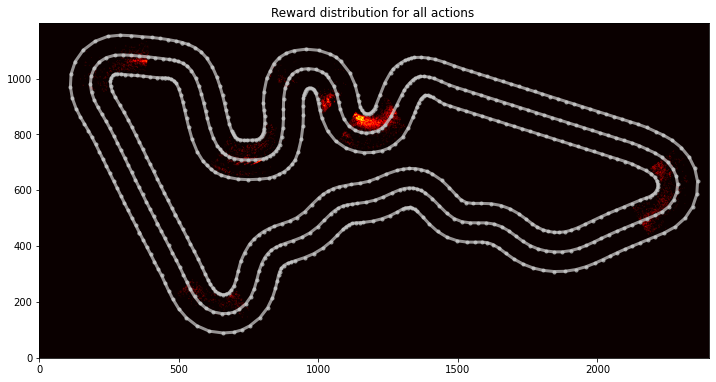

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: -18.9, throttle: 2.6


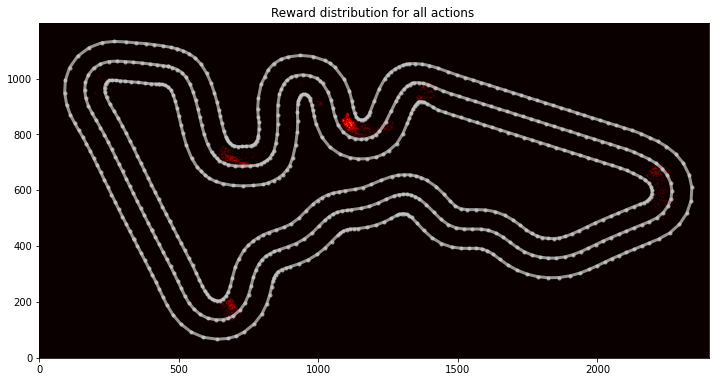

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: -12.1, throttle: 3.3


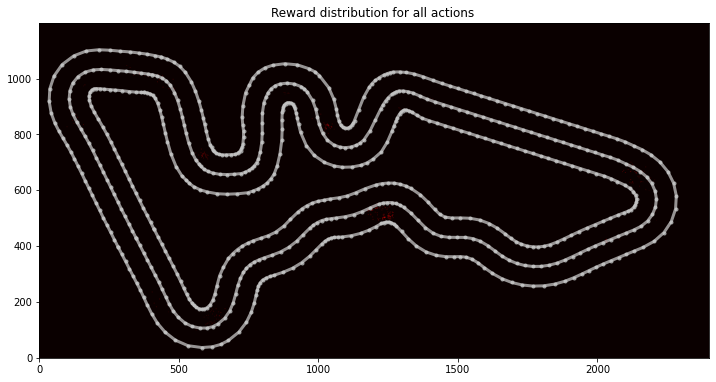

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: -8.0, throttle: 2.9


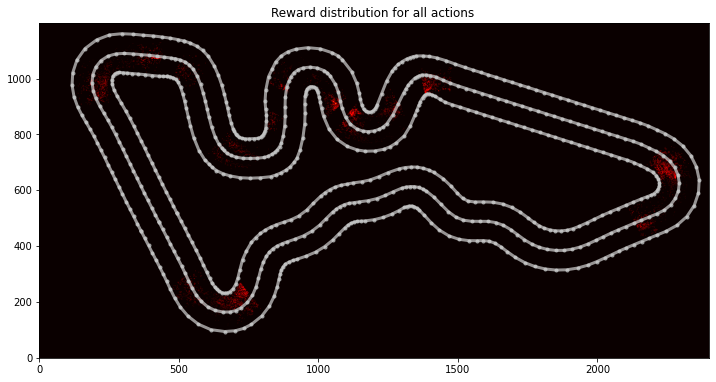

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: -6.0, throttle: 4.0


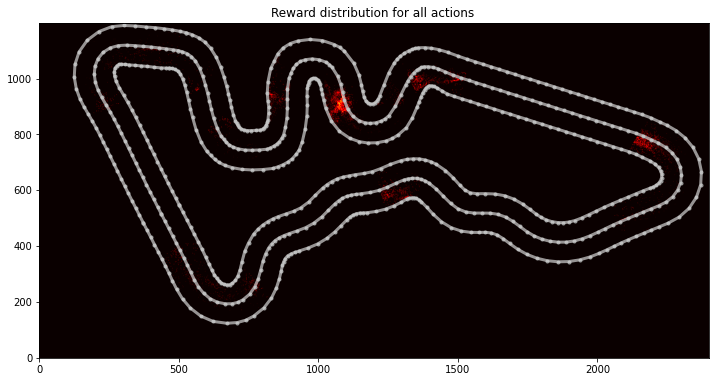

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: -3.4, throttle: 5.0


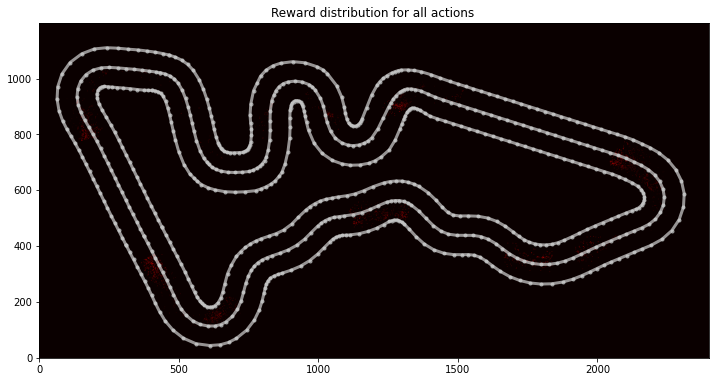

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: -2.7, throttle: 5.6


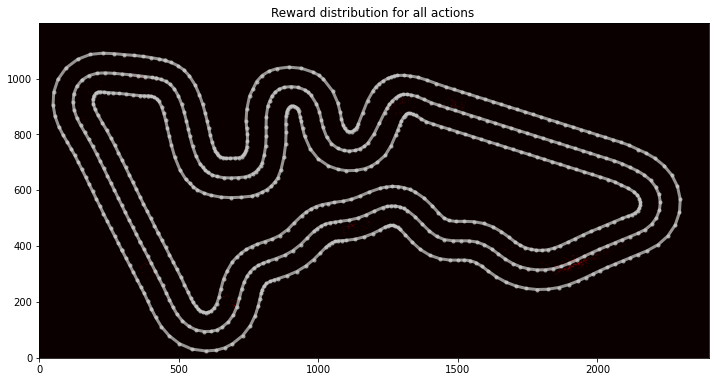

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: -0.5, throttle: 4.9


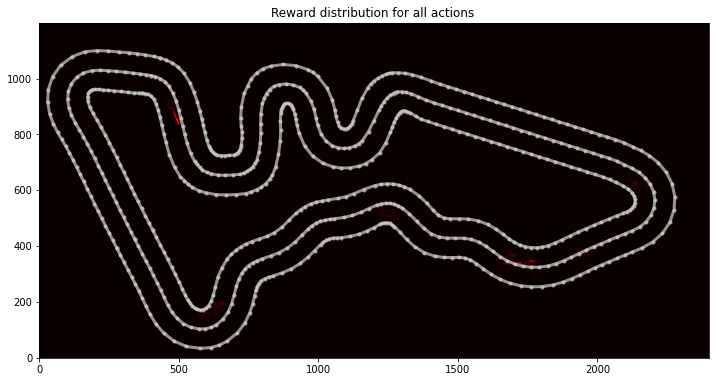

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: -0.3, throttle: 7.0


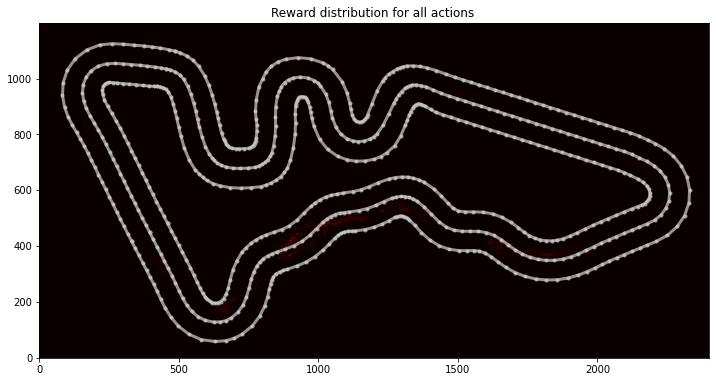

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 8.0


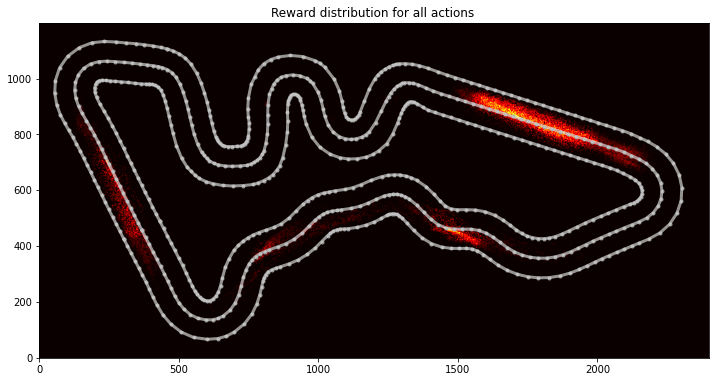

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: 0.9, throttle: 7.0


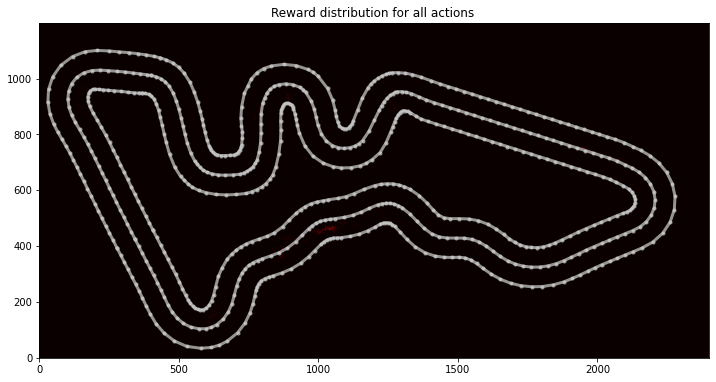

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: 3.6, throttle: 5.5


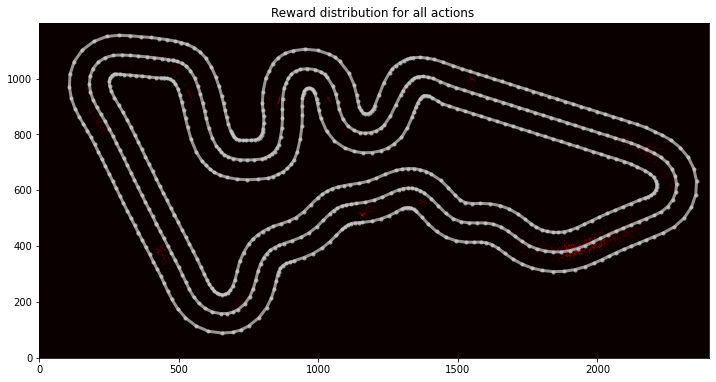

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 6.4, throttle: 4.0


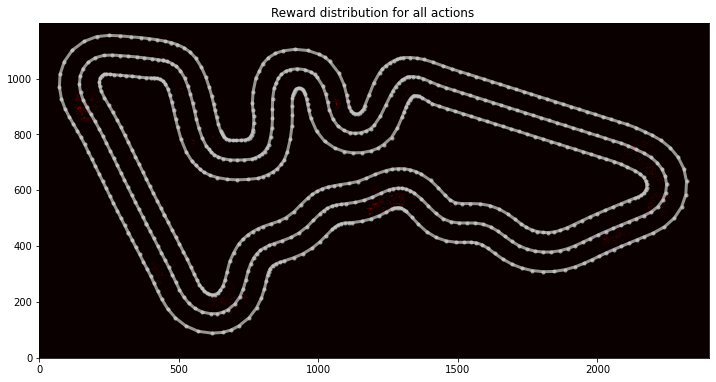

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 7.7, throttle: 3.5


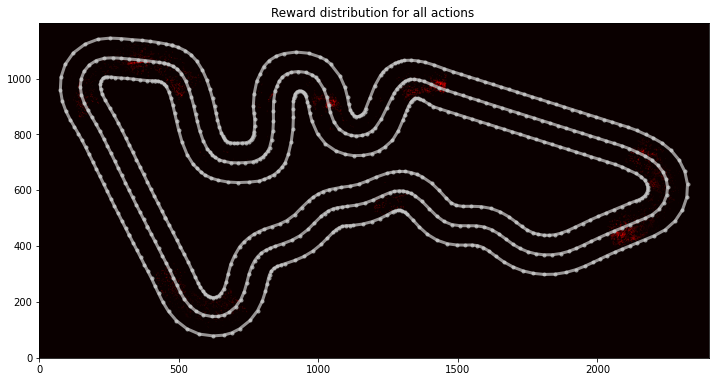

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: 8.5, throttle: 3.2


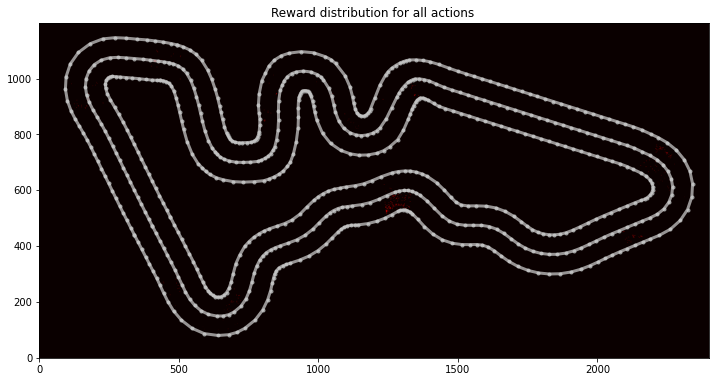

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 12.0, throttle: 2.5


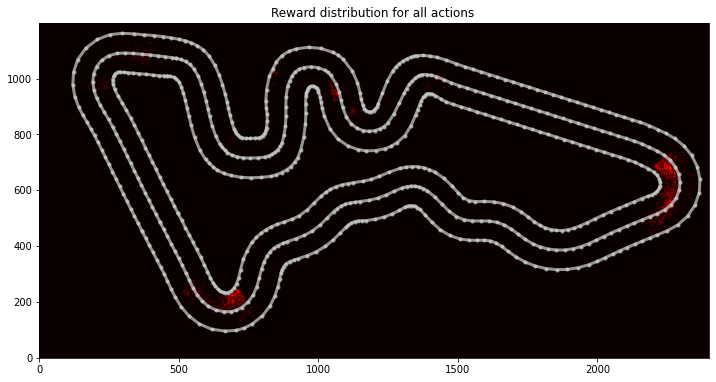

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: 15.2, throttle: 1.9


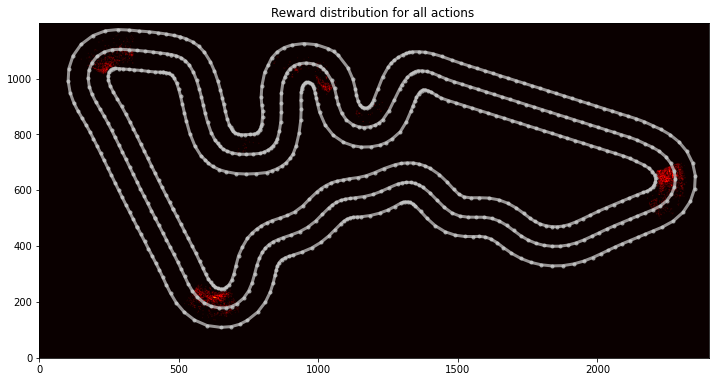

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 19.0, throttle: 1.7


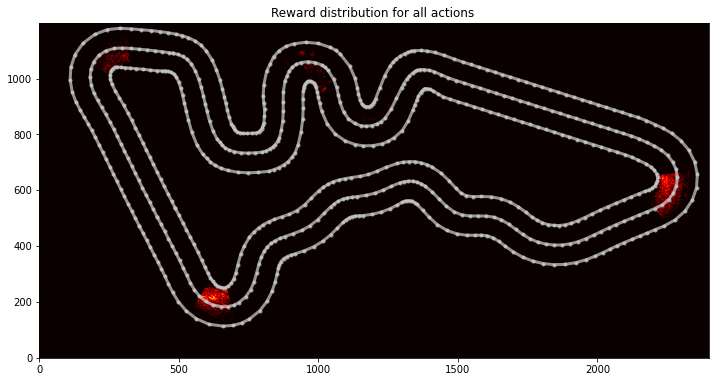

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 23.0, throttle: 1.6


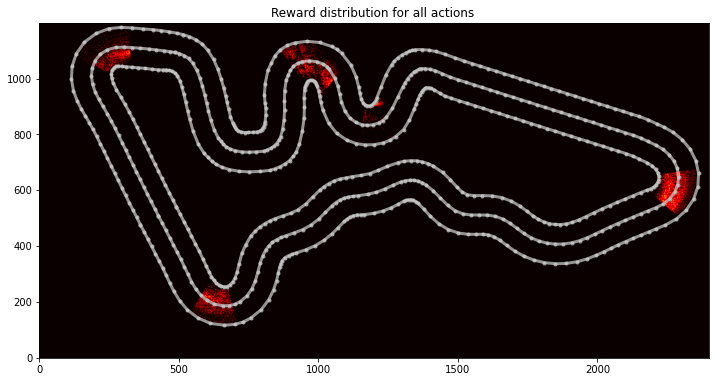

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: 30.0, throttle: 1.5


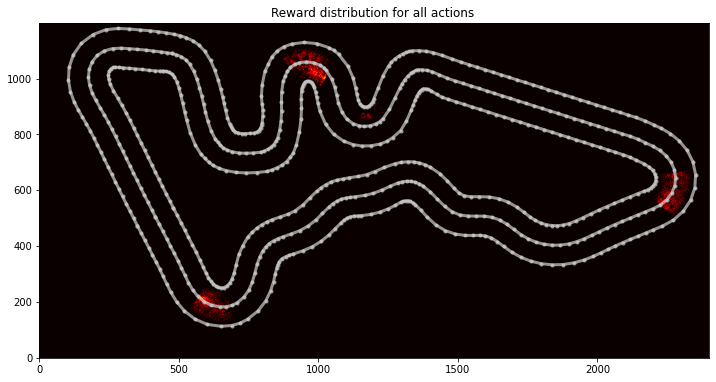

<Figure size 432x288 with 0 Axes>

In [40]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()